In [21]:
from python_graphql_client import GraphqlClient
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy
import itertools
import random

In [3]:
mapdata = dict()

with open('data/zonemap.json', 'r') as f:
    mapdata = json.load(f)

zones = mapdata['data']['zonesStats']
zones_map = {zone['zone']: zone['name'] for zone in zones}
channels = mapdata['data']['zonesGraphs']

In [ ]:
marketdata_raw = dict()
with open('data/marketcap.json', 'r') as f:
    marketdata_raw = json.load(f)

marketdata = dict()
for asset in marketdata_raw['data']['assets']:
    marketdata[asset['blockchain']['name']] = asset['marketCap']

In [5]:
G = nx.Graph()
for zone in zones:
    if zone['name'] in marketdata and marketdata[zone['name']] != None:
        market_cap = int(marketdata[zone['name']])
        G.add_node(zone['zone'], weight=market_cap)

for chan in channels:
    if chan["ibcVolume"] == 0:
        continue
    if chan["source"] not in G.nodes:
        continue
    if chan['target'] not in G.nodes:
        continue
    G.add_edge(chan["source"], chan["target"], weight=chan["ibcVolume"])

G

In [6]:
total_cap = 0

for node in G.nodes():
    total_cap += G.nodes[node]['weight']
print(total_cap)

9309518673


In [ ]:
def get_frequency(src, dst):
    f = open('data/peers/%s.json' % src, 'r')
    src_ibc_data = json.load(f)
    src_peers = src_ibc_data['data']['zones']
    for peer in src_peers:
        if dst == peer['data']['zoneChannels'][0]['zoneCounterparty']['zone']:
            ibcTransfers = peer['data']['aggregate']['sum']['ibcTransfers']
            frequency = ibcTransfers / 24.0
            return frequency # per hr

    return 0

def get_all_frequencies():
    zone_pairs = list(itertools.combinations(zones, 2))
    for pair in zone_pairs:
        zone0, zone1 = pair[0]['zone'], pair[1]['zone']
        frequency = get_frequency(zone0, zone1)
        print(zone0, zone1, frequency)

get_all_frequencies()

In [35]:
def aggregate_node_weights(G, path):
    """
    Calculate sum of the weights in a path.
    """
    return sum(G.nodes[node]['weight'] for node in path)

def find_heaviest_path(G, source, target, cutoff):
    """
    Find the heaviest path between source and target nodes.
    """
    max_path = []
    max_weight = 0
    for path in nx.all_simple_paths(G, source, target, cutoff=cutoff):
        weight = aggregate_node_weights(G, path)
        if weight > max_weight:
            max_path = path
            max_weight = weight
    return max_path, max_weight

def find_heaviest_path_all(G, cutoff=0):
    heaviest_path = []
    nodes = list(G.nodes)
    for src in nodes:
        max_path = [src]
        max_weight = G.nodes[src]['weight']
        for dst in nodes:
            max_path1, max_weight1 = find_heaviest_path(G, src, dst, cutoff)
            if max_weight1 >= max_weight:
                max_path = max_path1
                max_weight = max_weight1
        heaviest_path.append(max_weight)
        # print(src, max_path, max_weight)
    return heaviest_path

weights = find_heaviest_path_all(G)
weights

[2042957,
 195093115,
 2065271917,
 2124209,
 4658684,
 335412,
 3579937,
 207913511,
 275621160,
 410307266,
 49601676,
 3465034,
 7489574,
 1055873,
 21583765,
 128143599,
 58463084,
 243327564,
 2401290,
 5142306,
 675033,
 5293982,
 363583,
 32884461,
 9124539,
 13383824,
 98013118,
 4401823025,
 74,
 20801417,
 2459544,
 89933454,
 578605,
 33634711,
 29649398,
 119020954,
 73686889,
 24290976,
 141071925,
 27631335,
 186691004,
 5484565,
 88599486,
 1188529,
 47718118,
 57642288,
 6037012,
 18358207,
 85856684]

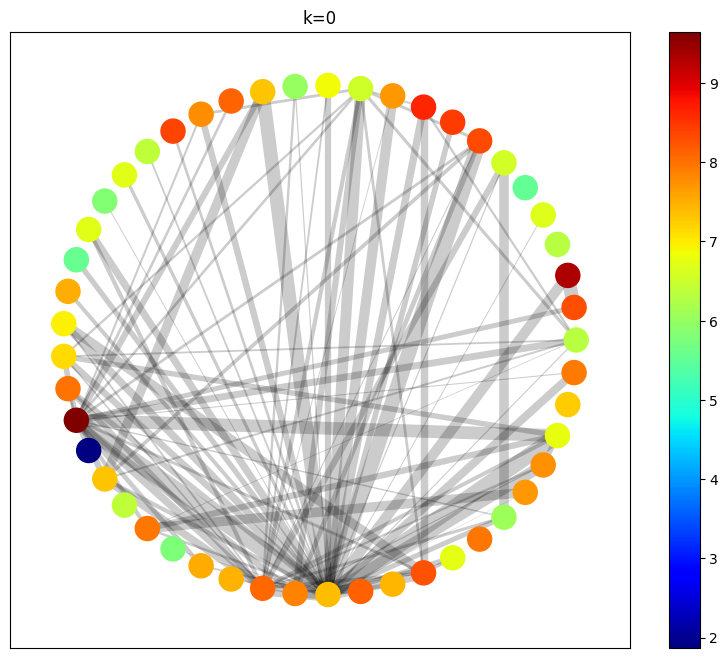

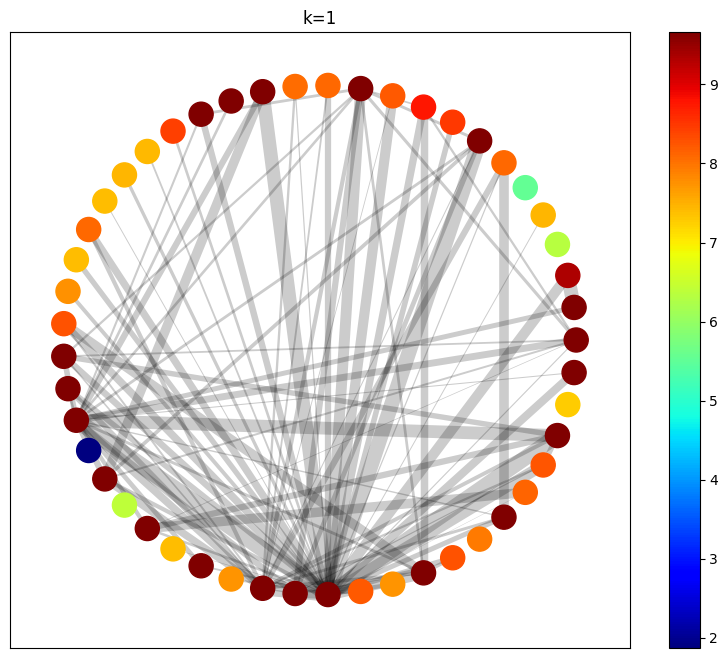

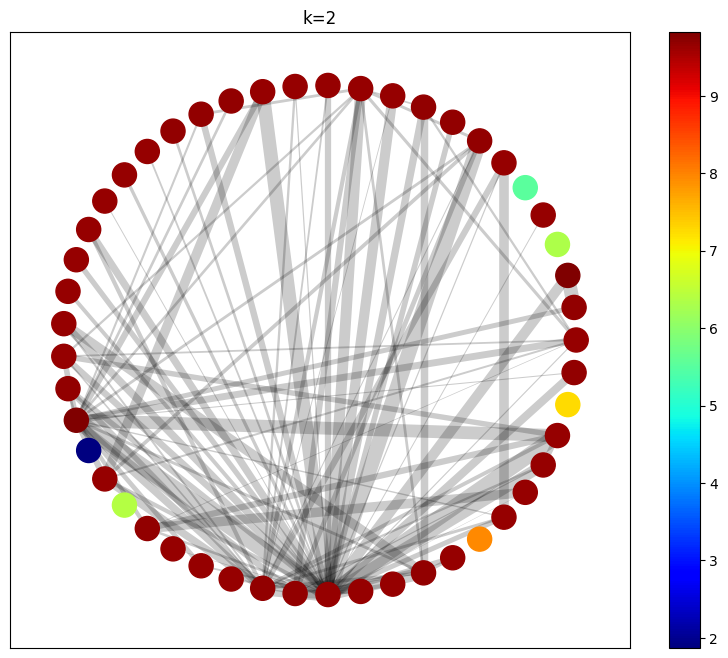

In [40]:
def draw_map_of_zones_summary(G, cutoff=0):
    node_labels = {node: zones_map[node] for node in G.nodes}
    # node_weights = [math.log10(G.nodes[node]['weight']) for node in G.nodes]
    node_weights = [math.log10(weight) for weight in find_heaviest_path_all(G, cutoff)]
    # edge_weights = [math.log10(edge[2]) for edge in G.edges(data='weight')]
    edge_weights = [math.log10(get_frequency(edge[0], edge[1]))*5 for edge in G.edges(data='weight')]

    fig = plt.figure(figsize=(10, 8))
    pos = nx.circular_layout(G)
    ec = nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=plt.cm.jet)
    # labels = nx.draw_networkx_labels(G,pos,node_labels,font_size=16,font_color='r')
    plt.colorbar(nc)
    plt.title('k=%d' % (cutoff))
    plt.show()

draw_map_of_zones_summary(G, 0)
draw_map_of_zones_summary(G, 1)
draw_map_of_zones_summary(G, 2)